# Implementation of **Word2Vec Algorithm using Skip Gram Model**

[Reference text](https://keras.io/examples/nlp/)

[Google Colab content](https://colab.research.google.com/drive/16wKOlwhx9lr8IvCqM4EXw-4007s713XS?usp=sharing)


References : [Main Source](https://analyticsindiamag.com/guide-to-word2vec-using-skip-gram-model/)

### The **word2vec** algorithm uses a neural network model to learn word associations from a large corpus of text.      

The continuous skip-gram model learns by predicting the surrounding words given a current word. In other words, the Continuous Skip-Gram Model predicts words within a certain range before and after the current word in the same sentence.

The Skip-Gram model is trained on n-gram pairs of (target_word, context_word) with a token as 1 and 0. The token specifies whether the context_words are from the same window or generated randomly. The pair with token 0 is neglected.   

**Code Implementation of Skip-Gram Model**

Steps to be followed:

Build the corpus vocabulary

Build a skip-gram [(target, context), relevancy] generator

Build the skip-gram model architecture

Train the Model
Get Word Embeddings

# 1. **Build the corpus vocabulary:**


The essential step while building any NLP based model is to create a corpus in which we extract each unique word from vocabulary and assign a unique numeric identifier to it.

In this article, the corpus we are using is ‘The King James Version of the Bible’, from Project Gutenberg, available free through the corpus model in nltk.

Import all dependencies:

In [ ]:
from nltk.corpus import gutenberg # to get bible corpus
from string import punctuation # to remove punctuation from corpus
import nltk
import re
import numpy as np



**TensorFlow** is an open-sourced end-to-end platform, a library for multiple machine learning tasks, while **Keras** is a high-level neural network library that runs on top of TensorFlow. Both provide high-level APIs used for easily building and training models, but Keras is more user-friendly because it's built-in Python.

**Keras** is a deep learning API written in Python, running on top of the machine learning platform TensorFlow. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result as fast as possible is key to doing good research. [https://keras.io/about]

The development team states that Keras is:

Simple — but not simplistic. Keras reduces developer cognitive load to free you to focus on the parts of the problem that matter.
Flexible — Keras adopts the principle of progressive disclosure of complexity: simple workflows should be quick and easy, while arbitrarily advanced workflows should be possible via a clear path that builds upon what you’ve already learned.
Powerful — Keras provides industry-strength performance and scalability: it is used by organizations and companies including NASA, YouTube, and Waymo.

Open https://colab.research.google.com/ and register for a free account

Create a new notebook within Colab

Select Runtime from the menu and Change the runtime type

Choose GPU from the Hardware accelerator options -

click save

In [ ]:
!pip install tensorflow

**import TensorFlow**

check that everything is set with the following few lines of code


In [ ]:
# import TensorFlow
import tensorflow as tf

#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We are set , where we tested the tensorflow, its version and made sure it is connected to GPU

In [ ]:
!pip install -q keras

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Import the Sequential model class from Keras
# to form the framework for a Sequential neural network:
from keras.models import Sequential

In [ ]:
#from tensorflow.keras.layers import Activation, Dense
# tensorflow 2.4.0, the Dense move from keras.layers.core move to tensroflow.keras.layers
# from keras.layers.core import Dense

#Please note if any module error comes, you need to check and find the right fix from Google!
#Many packages has shifted, if you are using old version, then it might give you different errors

In [ ]:
from keras.preprocessing import text
from keras.layers import LSTM
from keras.preprocessing.sequence import skipgrams
from keras.layers import *
from tensorflow.keras.layers import Dense, Reshape,Activation
from tensorflow.keras.layers import Embedding
from keras.models import Model,Sequential

Download gutenberg project, punkt model and stopwords from nltk as below:

In [ ]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


A user-defined function for text preprocessing that removes extra whitespaces, digits, and stopwords and lower casing the text corpus.

In [ ]:
bible = gutenberg.sents("bible-kjv.txt")
remove_terms = punctuation + '0123456789'
#removes all punctuation and digits from it

In [ ]:
bible

[['[', 'The', 'King', 'James', 'Bible', ']'], ['The', 'Old', 'Testament', 'of', 'the', 'King', 'James', 'Bible'], ...]

In [ ]:
wpt = nltk.WordPunctTokenizer()

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc,re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

Define a vectorized function which takes a nested sequence of objects or numpy arrays as inputs and returns a single numpy array or a tuple of numpy arrays.

Next, to extract unique word from the corpus and assigning a numeric identifier.

In [ ]:
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

In [ ]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1


wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:5])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5)]


2. **Build a Skip-Gram** [(target, context), relevancy] generator:

Keras functional API provides model skip-gram, which generate a sequence of word index into tuples of words of the form:


(word, word in the same window), with label 1 (positive samples)


(word, random word from the vocabulary), with label 0 (negative samples)

In [ ]:
# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0],
          id2word[pairs[i][1]], pairs[i][1],
          labels[i]))

(king (13), bible (5766)) -> 1
(king (13), james (1154)) -> 1
(king (13), pleasantness (10581)) -> 0
(bible (5766), unwalled (5976)) -> 0
(james (1154), blastus (11713)) -> 0
(james (1154), bible (5766)) -> 1
(bible (5766), king (13)) -> 1
(james (1154), village (3416)) -> 0
(bible (5766), wherewithal (7791)) -> 0
(james (1154), king (13)) -> 1


3. **Build the Skip-Gram model architecture:**

By using Keras with backend support of TensorFlow, we will build a deep learning architect of skip-gram.

Our input is targeted words, and context word pair means we need to process two inputs. This input is passed to a separate embedding layer to get word embedding for target and context words.

 Afterwards, we combine these two layers and pass the result to a dense layer that predicts either 1 or 0 depending on whether a pair of words is contextually relevant or just randomly generated.

In [ ]:
# build skip-gram architecture
embed_size = 100
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

merged_output = add([word_model.output, context_model.output])

model_combined = Sequential()
model_combined.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

final_model = Model([word_model.input, context_model.input], model_combined(merged_output))
final_model.compile(loss="mean_squared_error", optimizer="rmsprop")

final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 embedding_1_input (InputLa  [(None, 1)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               1242500   ['embedding_input[0][0]']     
                                                                                              

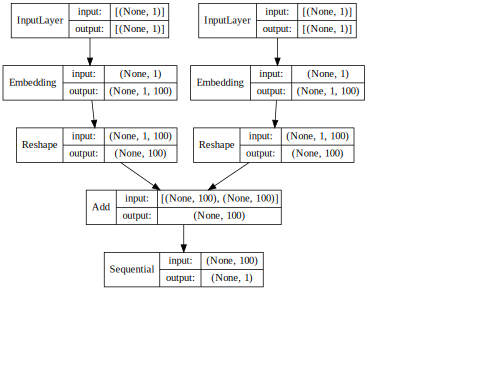

In [ ]:
# visualize model structure
from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model,model_to_dot

SVG(model_to_dot(final_model, show_shapes=True, show_layer_names=False,
                 rankdir='TB').create(prog='dot', format='svg'))

**4.Train the model:**

Training the model on a complete corpus takes more time; hence, we run a model for five epochs; you can increase the epochs if needed.

In [ ]:
for epoch in range(1, 3):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += final_model.train_on_batch(X,Y)

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 3462.401378194336
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 3345.8242130381986


**5. Get word embeddings:**

To get word embeddings for our entire vocabulary, we can extract the same from our embedding layer. We will extract the weights of embeddings from our word_model embedding layer.

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
                   for search_term in ['god', 'jesus','egypt', 'john', 'famine']}

similar_words

(12424, 12424)


{'god': ['confirm', 'disperse', 'strive', 'zophah', 'behaviour'],
 'jesus': ['submitted', 'jared', 'changing', 'blasphemest', 'illuminated'],
 'egypt': ['revenue', 'gins', 'grecians', 'stairs', 'fellows'],
 'john': ['mountains', 'eating', 'runneth', 'jehu', 'reserved'],
 'famine': ['teraphim', 'bondmen', 'person', 'stretcheth', 'rekem']}

# **Interpretation:**
We can see that the model gives nearly correct words related to the target word. Accuracy can be increased by training more epochs but note it will add more computational time

In [ ]:
! pip install gensim